# INFO-f422: ML Project

authors:
+ 1 
+ 2
+ 3

### Imports

In [7]:
import warnings
import numpy as np
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(threshold=3)

### Data loading

In [8]:
data_dir = "data"

X_g_train = np.load("../guided/guided_dataset_X.npy")
y_g_train = np.load("../guided/guided_dataset_y.npy")
X_g_test = np.load("../guided/guided_testset_X.npy")

X_f_train = np.load("../freemoves/freemoves_dataset_X.npy")
y_f_train = np.load("../freemoves/freemoves_dataset_y.npy")
X_f_test = np.load("../freemoves/freemoves_testset_X.npy")


In [9]:
print("Guided:")
print(f"X_g_train {X_g_train.shape} / y_g_train{y_g_train.shape} / X_g_test{X_g_test.shape}\n")
print("Free moves:")
print(f"X_f_train{X_f_train.shape} / y_f_train{y_f_train.shape} / X_f_test{X_f_test.shape}")

Guided:
X_g_train (5, 8, 230000) / y_g_train(5, 51, 230000) / X_g_test(5, 332, 8, 500)

Free moves:
X_f_train(5, 8, 270000) / y_f_train(5, 51, 270000) / X_f_test(5, 308, 8, 500)


### 1) Signal filtering

TODO: data exploration to take informed decision on filter (type of noise,....) to use and on filter parametres (no magic number)

In [5]:
from scipy.signal import butter, sosfiltfilt, firwin

In [6]:


def filtrage(x):
    nyq  = 1024 / 2
    low  = 20  / nyq
    high = 450 / nyq
    
    sos = butter(4,[low,high], btype='band', output= 'sos')
    
    for sess in range(x.shape[0]):
        for elec in range(x.shape[1]):
            # Application of the filtrage for x
            x[sess, elec, :] = sosfiltfilt(sos, x[sess, elec, :])

### 2) Dataset preparation

At the beginning, we implemented a naive function that loops for each windows needed. 

This version work but:
- Only when the step size can divides the total number of samples.  
- Copies every window into a new array, incurring  CPU overhead and unnecessary memory usage. 

In [10]:
def overlap(data, overlap=0.5, size=500):
    Data = []
    step = int(size * (1 - overlap))
    n = (data.shape[2] - size) // step + 1
    fin = n * step
    
    for start in range(0, fin, step):
        end = start + size
        W = data[... , start:end]
        Data.append(W)
        
    Data = np.array(Data)
    Data = Data.transpose(1, 0, 2, 3)
    return Data

But after some research, we decided to use the sliding_window_view function from the Numpy library for several reasons:

+ Fast vectorized numpy operations, compiled c-code (no python overhead, interpreter).

+ sliding_window_view function returns a view, no copy.

+ The function simplifies the implementation by automating window creation and indexing.

In [11]:
def create_overlap_windows(x, y, window_size, overlap, axis):

    step = int(window_size * (1 - overlap))

    # sliding_windows_view Generate all possible windows with the corresponding step, that not what we want.
    x_w = sliding_window_view(x,window_size,axis)
    y_w = sliding_window_view(y,window_size,axis)

    # only keep windows where the step is a multiple of our step 
    x_w = x_w[:,:,::step,:]
    y_w = y_w[:,:,::step,:]

    # We transpose the axes windows and electrode/signal 
    x_w = x_w.transpose(0, 2, 1, 3)     #  (session, window, electrode, time) and not  (session, electrode, window, time) TODO??
    y_w = y_w.transpose(0, 2, 1, 3)     # (session, window, signals, time)

    # Finaly, we keep only the last hand position (targets) for y, because for this project
    # we need to predict, for each window in x, the final hand position in the
    # same windows in the dataset y
    y_w = y_w[..., -1]  # (sessions, windows, targets)

    return x_w, y_w


X_g_train_wdw, y_g_train_wdw = create_overlap_windows(X_g_train, y_g_train, window_size=500, overlap=0.5, axis=2)
X_f_train_wdw, y_f_train_wdw = create_overlap_windows(X_f_train, y_f_train, window_size=500, overlap=0.5, axis=2)
# !! windowed data is a view --> share original data memory (modify one, modify both)

print("Guided windowed:")
print(f"X_g_train_wdw {X_g_train_wdw.shape} / y_g_train_wdw{y_g_train_wdw.shape} / X_g_test{X_g_test.shape}")
print(f"X_f_train_wdw {X_f_train_wdw.shape} / y_f_train_wdw{y_f_train_wdw.shape} / X_f_test{X_f_test.shape}")

Guided windowed:
X_g_train_wdw (5, 919, 8, 500) / y_g_train_wdw(5, 919, 51) / X_g_test(5, 332, 8, 500)
X_f_train_wdw (5, 1079, 8, 500) / y_f_train_wdw(5, 1079, 51) / X_f_test(5, 308, 8, 500)


In [12]:
def quick_windows_tests(x, y):
    # (maybe automate tests given windowsize and overlap and consider internal frag (shoudl be discarded)
    
    x_w, y_w = create_overlap_windows(x, y, window_size=500, overlap=0.5, axis=2)    
    
    assert np.array_equal(x_w[0, 0, 0, :10], x[0, 0, :10]) # (sess 0) first 10 of electrode 0 in window 0
    assert np.array_equal(x_w[0, 1, 0, :10], x[0, 0, 250:260]) # (sess 0) first 10 of electrode 0 in window 1
    assert np.array_equal(x_w[0, 1, 4, :10], x[0, 4, 250:260]) # (sess 0) first 10 of electrode 4 in window 1
    assert np.array_equal(x_w[0, 918, 0, -10:], x[0, 0, 229990:230000]) # (sess 0) last 10 of electrode 0 in last window (918) - (perfect fit!)

quick_windows_tests(X_g_train, y_g_train)

#### 3) Cross validation strategy

For this question, we have thought about various methods of cross validation. First, our data are continous because it's a signal, so preserving temporal structure is important. We can’t use a method of cross validation which randomly shuffles our windows. 

We also need to prevents data leaking so we can't use a methode who use the windows of one session for training AND validation because we have overlapping data in each session, two windows in the same session can share the same datas, and if these two windows are in train and validation, it will lead to data leakage and overly optimistic performance (data in the train set will also be in the validation set). 

So it's naturally that we have chosen the "Leave One Group Out" method, this method will use each session as the validation set once and the other for training. We completly prevent data leakage because each session is indepandent from the other, and we reduce the bias because each session will be used for validation.

In our case, "LOGO" and "GroupKFold(5)" produce the same splits, but we choose "LOGO" because it's more explicit, readers will immediatly see that we use one session for validation each time while "GroupKFold" need to have 5 in parameter to do the same thong

In [13]:
x_shape = X_g_train_wdw.shape
y_shape = y_g_train_wdw.shape

x_f_shape = X_f_train_wdw.shape
y_f_shape = y_f_train_wdw.shape


groups = np.repeat(np.arange(1,x_shape[0]+1),x_shape[1] ) # 111 (919 times), 222 (919 times), ...
print(f"groups{groups.shape}\n")

groups_f = np.repeat(np.arange(1,x_f_shape[0]+1),x_f_shape[1] ) 
print(f"groups_f{groups_f.shape}\n")

# We need to flatten the dataset x and y because the function logo (and latter "croos_val_score")
# want all the data in a 2d list, we will know have  the dataset X for exemple.
# [4595, 4000] and not [5,919,8,500], 4595 is the multiplication of 5 and 919 (3500 = 8*500), and y 
# [4595,51] and not [5,919,51].
# Now all the windows are store in a list and the "groups" list above allow the function 
# logo to know at wich session each windows belong
# The windows 3 for example (x_windows_flat[2]) belong to the sessions groups[2] = 1
X_g_train_wdw_flat = X_g_train_wdw.reshape(x_shape[0] * x_shape[1], x_shape[2] * x_shape[3])
y_g_train_wdw_flat = y_g_train_wdw.reshape(y_shape[0] * y_shape[1], y_shape[2])

X_f_train_wdw_flat = X_f_train_wdw.reshape(x_f_shape[0] * x_f_shape[1], x_f_shape[2] * x_f_shape[3])
y_f_train_wdw_flat = y_f_train_wdw.reshape(y_f_shape[0] * y_f_shape[1], y_f_shape[2])

print("Guided windowed flattened:")
print(f"X_g_train_wdw_flat{X_g_train_wdw_flat.shape} / y_g_train_wdw_flat{y_g_train_wdw_flat.shape}")

print("Free windowed flattened:")
print(f"X_f_train_wdw_flat{X_f_train_wdw_flat.shape} / y_f_train_wdw_flat{y_f_train_wdw_flat.shape}")

groups(4595,)

groups_f(5395,)

Guided windowed flattened:
X_g_train_wdw_flat(4595, 4000) / y_g_train_wdw_flat(4595, 51)
Free windowed flattened:
X_f_train_wdw_flat(5395, 4000) / y_f_train_wdw_flat(5395, 51)


In [32]:
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score,cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.multioutput import MultiOutputRegressor



In [15]:
# %%time

# np.random.seed(0)

logo = LeaveOneGroupOut()

lasso_model = Lasso(max_iter=10) # If the iteration is higher, it take to much time, even on collab 
'''# If you don't want the warning but prepare your afternoon for the runtime 
lasso_model = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso',   Lasso(alpha=0.1, max_iter=20000))
])'''


rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False  # Score near 0 is better 
)

def cross_validation_with_scores(X,Y,groups,model,cv,scoring):
    # The cross_val_score function by sklearn will execute our cv and return a tab 
    neg_rmse_scores = cross_val_score(
        model,
        X,
        Y,
        groups=groups,
        cv=cv,
        scoring=rmse_scorer,
        n_jobs=-1 # Use all cores 
    )
    
    # Conversion of negatifs scores into positifs (convention of sklearn)
    rmse_scores = -neg_rmse_scores  
    print("RMSE for each folder:", rmse_scores)
    print("RMSE mean:", rmse_scores.mean())


In [66]:
#Guided 
cross_validation_with_scores(X_g_train_wdw_flat,y_g_train_wdw_flat,groups,lasso_model,logo,rmse_scorer)

#Free
cross_validation_with_scores(X_f_train_wdw_flat,y_f_train_wdw_flat,groups_f,lasso_model,logo,rmse_scorer)

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


RMSE for each folder: [17.94011704 18.68652126 20.46060078 17.30326328 19.3046778 ]
RMSE mean: 18.739036031720634
RMSE for each folder: [17.80702643 16.56398358 16.04999994 15.49969335 13.02059498]
RMSE mean: 15.788259656326385


In [16]:
# rmse context
sess = 0
y_max = np.max(y_g_train_wdw[sess])
y_min = np.min(y_g_train_wdw[sess])
y_mean = np.mean(y_g_train_wdw[sess])

print(f"Session {sess} target info:\n  min = {y_min}\n  max = {y_max}\n  mean = {y_mean}")

Session 0 target info:
  min = -108.68231864942676
  max = 44.76897408739836
  mean = -5.73247691191569


In [17]:

for i, (train_index, test_index) in enumerate(logo.split(X_g_train_wdw_flat, y_g_train_wdw_flat, groups)):
    print(f"Fold {i}")
    print(f"   train groups: {np.unique(groups[train_index])}")
    print(f"   test groups: {np.unique(groups[test_index])}")

Fold 0
   train groups: [2 3 4 5]
   test groups: [1]
Fold 1
   train groups: [1 3 4 5]
   test groups: [2]
Fold 2
   train groups: [1 2 4 5]
   test groups: [3]
Fold 3
   train groups: [1 2 3 5]
   test groups: [4]
Fold 4
   train groups: [1 2 3 4]
   test groups: [5]


#### 5) More sophisticated approach

For this question, we decided to implement the two approaches in order to have a better understanding and more methods to compare.

We started with the covariance approch, following the steps in section 3.2:

- We first calculate the covaraince of each windows with the PyRiemmann Covariances class, which expects a 3d array, so we need to reshape it into the form (windows,electrode,time). After using this class, we obtain an array of 8×8 covariance matrices (SPD_tab) for each window.

- Next, we map each SPD matrix into their tangent space using the TangentSpace class. This projection transforms our SPD matrices into Euclidean vectors. Thanks to this, our dataset becomes 2D again, and we can directly use a traditional regression algorithms and sklearn function.
  

In [18]:
#pip install pyriemann
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.pipeline     import Pipeline
from sklearn.preprocessing import StandardScaler


In [19]:
# Covariances method


# Reshape the flattten dataset
X_g_train_reshape = X_g_train_wdw_flat.reshape(4595,8,500)

X_f_train_reshape = X_f_train_wdw_flat.reshape(5395,8,500)

'''
covariance = Covariances(estimator='oas')
SPD_tab = covariance.fit_transform(X_g_train_reshape) 
# print(SPD_tab.shape) # (4595,8,8)
ts = TangentSpace()
tangent_tab = ts.fit_transform(SPD_tab)
# print(tangent_tab.shape) # (4595,36) Now that we have a 2d tab, we can use traditional regression algorithms
'''

pipe_cov = Pipeline([
    ('cov',    Covariances(estimator='oas')),   # Covariances matrices of each windows
    ('ts',     TangentSpace()),                 # This projection will transform our SPD matrices into euclidean vector
    ('scale', StandardScaler()),          # Standardize each feature (mean =0, std =1) 
    ('lasso',  lasso_model)               # Lasso model 
])



In [20]:
# Now we juste need to use the cv function we build above 
#Guided 
cross_validation_with_scores(X_g_train_reshape,y_g_train_wdw_flat,groups,pipe_cov,logo,rmse_scorer)

#Free 
cross_validation_with_scores(X_f_train_reshape,y_f_train_wdw_flat,groups_f,pipe_cov,logo,rmse_scorer)


/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.225e+01, tolerance: 4.499e+00
  model = cd_fast.enet_coordinate_descent(
/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.743e+03, tolerance: 4.204e+01
  model = cd_fast.enet_coordinate_descent(
/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

RMSE for each folder: [8.21531223 7.74146158 7.93251768 6.92650706 7.90240062]
RMSE mean: 7.743639831450407


/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.377e+02, tolerance: 6.182e+01
  model = cd_fast.enet_coordinate_descent(
/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.075e+03, tolerance: 9.952e+01
  model = cd_fast.enet_coordinate_descent(
/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

RMSE for each folder: [10.60965401 12.45418765 11.22372944  9.79798601  9.58054703]
RMSE mean: 10.733220829146067


For the neural network approch, we have done:

##### Simple model
We started by a simple model composed of 3 linear layers.

To evaluate it, we used Skorch, which lets us plug a PyTorch nn.Module into a sklearn function.
Thanks to Skorch, we could reuse our existing cross_validation_with_scores() function.

The rmse mean was 17.03, which beat the vanilla lasso model but not the covriance matrices lasso. We analyzed the value of the training loss and validation loss for each epoch and we saw that the model is underfitting.
So we decide to complexify it.

##### Model complexity

We upgraded to a small CNN with three 1D convolutional layers because the dataset has to much datas for an nn classique and to automatically learn local temporal patterns in the EMG signal. 

After each convolutional layer:

We normalize our data to stabilize and speed up training.

We introduce a simple Relu activation so the network can learn more complex features.

We “cut” the time dimension in half, keeping only the strongest responses and reducing data size.

Once the three convolutional blocks are done, we flatten the output tensor and pass it into a two layer head, to convert these extracted features into the 51 joint-angle predictions

##### Early stopping and LR scheduling

We added two Skorch callbacks:

-EarlyStopping to stop the training when no improvement is seen for 10 epochs.

-LRScheduler to cut the learning rate by half when the validation loss stalls 3 epochs consecutives.

This combination prevents wasted epochs once the model converges and refines the learning rate to squeeze out extra gains.

##### Batch size reduction

We lowered the batch size from 128 to 64. Using smaller batches adds a bit of randomness to each weight update, which helps the model generalize better without altering its structure.

With these three changes, the nn average RMSE dropped to ~5.07, a dramatic improvement over the initial ~17.

| Simple Model | Complex Model | Complex Model + Early Stopping & LR Scheduler | Same as #3 but Batch Size = 64 |
|:------------:|:-------------:|:---------------------------------------------:|:-----------------------------:|
| ![](./images/1.png) | ![](./images/2.png) | ![](./images/3.png) | ![](./images/4.png) |
| **RMSE mean:** 17.03 | **RMSE mean:** 6.06 | **RMSE mean:** 5.89 | **RMSE mean:** 4.87 |


In [21]:
# pip install -U skorch
import torch
import torch.nn as nn
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from skorch.callbacks import LRScheduler



In [45]:
## NN method

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Unflatten(1, (8,500)), #unflatten data for  convolution (64 (batch_size), 8,500)

            nn.Conv1d(8, 32, kernel_size=11, padding=5), # 8 input channels (electrodes) and 32 is the output, the number of feature he learn.
            # Thanks to padding, the output length remains 500 (64,32,500) 
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),  # Halve the temporal dimension  (64,32,250)          
            
            nn.Conv1d(32, 64, kernel_size=9, padding=4), #(64,64,250)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),  #(64,64,125)      

            nn.Conv1d(64, 128, kernel_size=7, padding=3), # (64,128,125)
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),  # (64,128,62)    
            
            nn.Flatten(), # Reflatten our data for the next part (64,128*62)
        )
        self.r = nn.Sequential(
            nn.Linear(7936, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 51),
        )

    def forward(self, x):
        x = self.f(x)
        return self.r(x)

      
# Convert dataset from float64 to float32 because PyTorch layers expect float32
# 32-bit precision is sufficient for our signals and speeds up training
print(X_g_train_wdw_flat.dtype)   
print(y_g_train_wdw_flat.dtype)   

x = X_g_train_wdw_flat.astype('float32')
y = y_g_train_wdw_flat.astype('float32')

x_f = X_f_train_wdw_flat.astype('float32')
y_f = y_f_train_wdw_flat.astype('float32')


net = NeuralNetRegressor(
    module=NeuralNetwork,                 # PyTorch model 
    max_epochs=100,                 
    lr=1e-3,                       
    batch_size=64,
    optimizer=torch.optim.Adam,
    callbacks=[('earlystop', EarlyStopping('valid_loss', patience=10)), # Stop if validation loss doesn't improve for 5 epochs 
                    ('lr_sched', LRScheduler(
           policy=torch.optim.lr_scheduler.ReduceLROnPlateau, # Halve LR if validation loss stalls for 3 epochs
           monitor='valid_loss',
           patience=3, factor=0.5))]
)


pipe_cnn = Pipeline([
    ('scale', StandardScaler()),  # Standardize inputs for a quick start, after the cnn will then normalize its data at each step
    ('net',   net)                
])

float64
float64


In [67]:
#Guided
cross_validation_with_scores(x,y,groups,pipe_cnn,logo,rmse_scorer)

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/khal

Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      183.7466      117.0032  0.0010  12.0949
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      189.3073      126.2191  0.0010  12.0673
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      180.7975      117.4314  0.0010  12.1996
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      197.3731      121.0930  0.0010  12.2818
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_los

In [64]:
#Free
cross_validation_with_scores(x_f,y_f,groups_f,pipe_cnn,logo,rmse_scorer)

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/khal

  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      219.1000      293.1583  0.0010  13.9384
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      224.9589      242.9936  0.0010  14.0721
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      222.1733      205.4595  0.0010  14.1591
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      231.9693      148.7291  0.0010  14.1602
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      199.9677      221.3613  0.0010  14.1809
      2      177.8046      210.1426  0.0010  14.1591
      2      162.1591      184.0694  0.0010  14.1777
      2      156.1242      254.2190  0.0010  14.4730
      2      150.9769      141.5371  0.0010  1

The mean rmse for this cnn was better than that of the covariance pipeline, but it takes a really long time to execute compared to that method. If only I could have the benefits of both approaches…

It was with this train of thought that I created a hybrid between the cnn and the covariance matrice method. For this hybrid, I didn’t need a CNN because the data after the covariance matrice step was  small, so I just built a two-layer nn and the results are very close to the cnn but it runs much faster.

In [23]:
from sklearn.preprocessing import FunctionTransformer

#Small nn
class Cov_nn(nn.Module):
    def __init__(self):
        super().__init__()
        self.s = nn.Sequential(
          nn.Linear(36, 128),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(64, 51)
        )

    def forward(self, x):
        return self.s(x)

net_nn2 = NeuralNetRegressor(
    module      = Cov_nn,
    max_epochs  = 200,
    lr          = 1e-3,
    batch_size  = 64,
    optimizer   = torch.optim.Adam,
    callbacks=[('earlystop', EarlyStopping('valid_loss', patience=5)), # Stop if validation loss doesn't improve for 5 epochs 
                    ('lr_sched', LRScheduler(
           policy=torch.optim.lr_scheduler.ReduceLROnPlateau, # Halve LR if validation loss stalls for 3 epochs
           monitor='valid_loss',
           patience=3, factor=0.5))]
)


pipe_fusion = Pipeline([
    ('cov',   Covariances(estimator='oas')),   
    ('ts',    TangentSpace()),                
    ('scale', StandardScaler()),               
    ('cast',  FunctionTransformer(lambda X: X.astype(np.float32), validate=False)), # cast to float32 for PyTorch compatibility
    ('nn',   net_nn2)                          
])

x_cov_nn = X_g_train_reshape.astype('float32')
x_cov_nn_f = X_f_train_reshape.astype('float32')


In [25]:
#Guided
cross_validation_with_scores(x_cov_nn,y,groups,pipe_fusion,logo,rmse_scorer)

#Free 
cross_validation_with_scores(x_cov_nn_f,y_f,groups_f,pipe_fusion,logo,rmse_scorer)

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/khal

Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      463.9438      385.1099  0.0010  0.1092
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      456.9825      375.9054  0.0010  0.1149
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      463.5073      379.5745  0.0010  0.1192
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      467.8356      396.4691  0.0010  0.1442
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_loss      lr     dur

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/khal

Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      701.7604      465.9023  0.0010  0.1618
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      640.2996      458.6602  0.0010  0.1509
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      569.2093      838.9061  0.0010  0.1490
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      676.5895      444.7971  0.0010  0.1426
      2      391.0130      191.6481  0.0010  0.1565
Stopping since valid_loss has not improved in the last 5 epochs.

![](./images/5.png)

  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      440.9353      321.2495  0.0010  0.0966
      2      217.0207      147.0345  0.0010  0.0863
      3      150.9787      126.6180  0.0010  0.0839
      4      128.9234      113.5365  0.0010  0.0789
      5      112.8172      102.9149  0.0010  0.0844
      6      101.2874       94.7909  0.0010  0.0836
      7       93.6632       87.5280  0.0010  0.0794
      8       87.4154       81.7757  0.0010  0.0878
      9       83.5102       77.0341  0.0010  0.0810
     10       79.0211       72.6960  0.0010  0.0789
     11       75.2462       68.3102  0.0010  0.0781
     12       70.8998       65.9711  0.0010  0.0883
     13       67.6282       61.6043  0.0010  0.0868
     14       65.3987       59.3400  0.0010  0.0918
     15       63.0777       58.0101  0.0010  0.0833
     16       60.6039       54.9997  0.0010  0.0928
     17       57.8418       53.6849  0.0010  0.0797
     18     

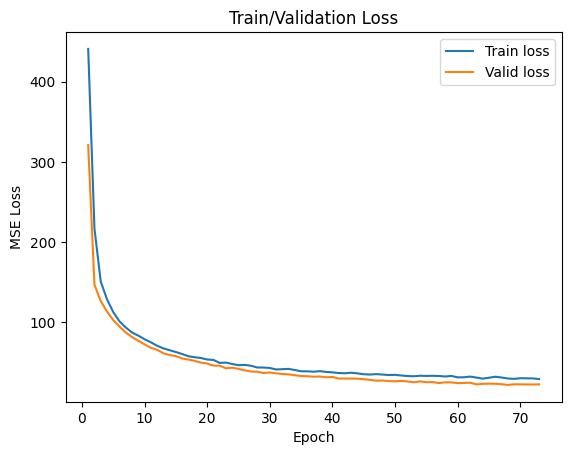

Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      620.4384      382.0728  0.0010  0.0926
      2      270.6949      160.4806  0.0010  0.0883
      3      159.3039      141.4028  0.0010  0.1016
      4      147.8866      135.0690  0.0010  0.0867
      5      141.7053      130.9750  0.0010  0.0879
      6      137.1370      128.6216  0.0010  0.0977
      7      132.9875      127.1554  0.0010  0.0947
      8      129.0842      126.0535  0.0010  0.0989
      9      125.7572      125.0518  0.0010  0.1004
     10      122.5381      122.8381  0.0010  0.1030
     11      121.2748      122.6606  0.0010  0.1070
     12      118.2585      122.0661  0.0010  0.1103
     13      116.8067      121.1448  0.0010  0.1003
     14      114.8546      120.8670  0.0010  0.1014
     15      113.6295      119.8187  0.0010  0.0901
     16      111.9878      119.1762  0

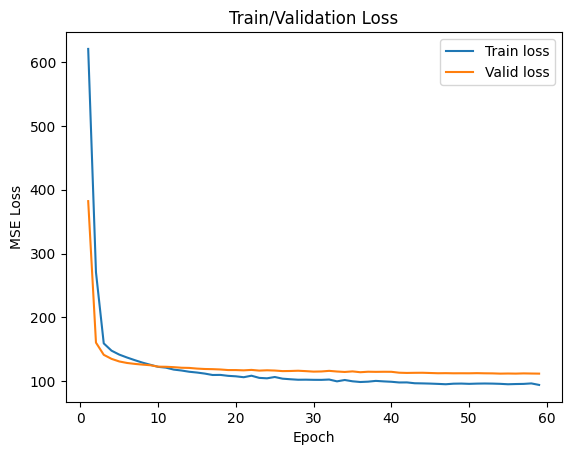

In [39]:
import matplotlib.pyplot as plt



def plot(pipeline):
    history = pipeline.named_steps['nn'].history
    
    epochs = history[:, 'epoch']
    train_loss = history[:, 'train_loss']
    valid_loss = history[:, 'valid_loss']
    
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Train/Validation Loss')
    plt.legend()
    plt.show()

pipe_fusion.fit(x_cov_nn, y)
plot(pipe_fusion)
pipe_fusion.fit(x_cov_nn_f, y_f)
plot(pipe_fusion)

| Method                                   | RMSE Guided | RMSE  Free |
|------------------------------------------|-------------------|------------------:|
| Basic Lasso                              |      18.73 | 15.78 |
| Baseline approach                        |        –   | |
| Covariance matrices + Lasso              |       7.36 | 10.45 |
| Covariance matrices + Neural Network     |       5.02 | 10.61|
| Convolutional Neural Network             |       4.54 | 11.51|




 

When we compare the progression of our models, we see that incorporating covariance matrices into a simple Lasso regressor brings the rmse down about 62 % over the basic Lasso. 

...

Moving on to a small neural network trained on those 36 tangent‐space features further reduces the error to 5.02, which represents a 39 % drop. Finally, the cnn achieves the lowest rmse of 4.87, a modest 3 % gain over the covariance nn hybrid.

That last 3 % improvement, however, comes at a cost, the cnn is significantly more complex to train and deploy.



#### Question 6

For this question, we have ... regression models trained on different feature representations:

- ...
- Tangentes spaces of the signal using the NN + Covariance Matrice
- Filtered raw signal data using a CNN


To obtain each models predictions, we use cross_val_predict, which is essentially the same as cross_val_score but returns the predictions of each fold instead of the scores.

In [46]:
# Prediction of each model for the guided and free dataset 

... #Other models 

y_g_predict_cnn = cross_val_predict(pipe_cnn,x, y, groups=groups, cv=logo, n_jobs=-1)
y_f_predict_cnn = cross_val_predict(pipe_cnn,x_f, y_f, groups=groups_f, cv=logo, n_jobs=-1)

y_g_predict_nn_covariance = cross_val_predict(pipe_fusion, x_cov_nn, y, groups=groups, cv=logo, n_jobs=-1)
y_f_predict_nn_covariance = cross_val_predict(pipe_fusion, x_cov_nn_f, y_f, groups=groups_f, cv=logo, n_jobs=-1)


# Rajouter les prédictions de vos modéles 
y_g_predict_ensemble = (y_g_predict_cnn + y_g_predict_nn_covariance) / 2 
y_f_predict_ensemble = (y_f_predict_cnn + y_f_predict_nn_covariance) / 2 


/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/khal

  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      191.3013      143.4341  0.0010  12.4011
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      187.2134      107.6620  0.0010  12.4745
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      183.5272      110.6196  0.0010  12.3992
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      193.4070      122.9238  0.0010  12.5195
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      193.1418      112.7577  0.0010  12.6176
      2       85.6173      123.5681  0.0010  12.8952
      2       83.1987       73.6641  0.0010  12.9517
      2       90.6465       75.2312  0.0010  13.1417
      2       90.5304      204.3325  0.0010  1

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/khal

Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      202.3417      246.4941  0.0010  16.1925
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      222.5009      325.6901  0.0010  16.3302
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      235.5505      158.1878  0.0010  17.4147
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      229.7112      236.8569  0.0010  17.4311
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1      218.7376      240.9786  0.0010  17.6249
      2      150.4913      146.1385  0.0010  16.7478
      2      155.371

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/khal

Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      467.1504      389.7523  0.0010  0.1806
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      463.8901      394.7422  0.0010  0.1725
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      466.2013      377.7791  0.0010  0.1789
Stopping since valid_loss has not improved in the last 10 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      462.8545      387.7727  0.0010  0.1818
      2      276.3389      178.4213  0.0010  0.1911


/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)


      2      275.5117      171.5878  0.0010  0.1601
      2      269.1371      174.5052  0.0010  0.1755
      2      274.2269      175.8727  0.0010  0.1609
      3      162.3603      138.3615  0.0010  0.1358
      3      168.8254      135.7524  0.0010  0.1704
      3      168.9225      142.9974  0.0010  0.1588
      3      166.6689      137.2368  0.0010  0.1450
      4      148.0222      131.0682  0.0010  0.1717
      4      143.0514      121.9338  0.0010  0.1784
      4      139.4087      125.0824  0.0010  0.1913
      4      142.7894      123.0034  0.0010  0.1874
      5      125.6431      111.8823  0.0010  0.1612
      5      122.4297      113.3558  0.0010  0.1591
      5      131.5352      121.3479  0.0010  0.1868
      5      127.5069      110.6329  0.0010  0.1424
      6      109.5848      103.5144  0.0010  0.1642
      6      107.6336      104.8038  0.0010  0.1748
      6      117.9264      108.9451  0.0010  0.1897
      6      113.2596      100.1538  0.0010  0.2346
      7     

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/skorch/net.py:2261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load_kwargs)
/home/khal

Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      694.9308      444.4900  0.0010  0.2270
Stopping since valid_loss has not improved in the last 5 epochs.
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1      683.9242      469.9486  0.0010  0.1965
      2      362.9705      180.0991  0.0010  0.2443
      2      391.0144      198.4933  0.0010  0.2144
      3      181.8966      143.9808  0.0010  0.2087
      3      188.7483      152.0237  0.0010  0.2122
      4      162.4341      135.3354  0.0010  0.2059
      4      160.1824      142.2912  0.0010  0.2179
      5      155.8434      131.4308  0.0010  0.2065
      5      151.6390      136.5566  0.0010  0.2302
      6      150.1104      128.2111  0.0010  0.1979
      6      144.7474      132.1397  0.0010  0.2181
      7      146.6436      125.3755  0

In [48]:
def calculate_metrics(y,y_predict):
    mse  = mean_squared_error(y, y_predict)
    rmse = np.sqrt(mse)
    nmse = mse / np.var(y)  
    return rmse, nmse 


# Metrics Guided
rmse_g_cnn,   nmse_g_cnn   = calculate_metrics(y, y_g_predict_cnn)
rmse_g_nn,    nmse_g_nn    = calculate_metrics(y, y_g_predict_nn_covariance)
rmse_g_ens,   nmse_g_ens   = calculate_metrics(y, y_g_predict_ensemble)


# RMSE Free
rmse_f_cnn,   nmse_f_cnn   = calculate_metrics(y_f, y_f_predict_cnn)
rmse_f_nn,    nmse_f_nn    = calculate_metrics(y_f, y_f_predict_nn_covariance)
rmse_f_ens,   nmse_f_ens   = calculate_metrics(y_f, y_f_predict_ensemble)


print(rmse_g_cnn,rmse_g_nn,rmse_f_cnn, rmse_f_nn)
print(nmse_g_cnn,nmse_g_nn,nmse_f_cnn, nmse_f_nn)

print("RMSE scores of the average method guided:", rmse_g_ens, "and free :",rmse_f_ens)
print("NMSE scores of the average method guided:", nmse_g_ens, "and free :",nmse_f_ens)

4.605793431091196 5.153238977914858 11.808756563134953 10.61510051232294
0.04567055 0.057172593 0.2410565 0.19478644
RMSE scores of the average method guided: 4.479452907671961 and free : 10.578227055337646
NMSE scores of the average method guided: 0.043199357 and free : 0.19343555


At this point we have our ensemble predictions (y_ensemble) and all the metrics we need for the average method. The power of this approach depends not only on each models individual performance but also on the diversity of their errors. Because we weight every model equally, a very weak model can drag the average down.

However, when all the models are accurate enough and make different kinds of mistakes, averaging becomes extremely effective. For example, our CNN excels at learning local, spatial patterns in the raw filtered signal, while our nn + covariance network captures global statistical dependencies over time. Their errors rarely coincide, so when the CNN prediction is off for a given sample, the nn model often compensates it, and vice-versa. By averaging their outputs, we reduce the total variance and achieve a lower rmse/nmse than either model on its own, all without any extra hyperparameter tuning


For the second method, we concatenate the predictions of our models into a new dataset. This dataset will have the form (n_windows, targets × M), with M being the number of different models. After that, we train our model on this data and calculate the RMSE compared to the true y.

In [72]:
# Creation of the new dataset with the prediction of our models 
x_g_meta = np.concatenate([y_g_predict_cnn, y_g_predict_nn_covariance], axis=1)
x_f_meta = np.concatenate([y_f_predict_cnn, y_f_predict_nn_covariance], axis=1) 

# model 
lasso_model = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso',  Lasso(alpha=0.1, max_iter=20000))
    ])

# Calculate the prediction
y_g_predict_stack = cross_val_predict(lasso_model,x_g_meta,y,groups=groups,cv=logo,n_jobs=-1)
y_f_predict_stack = cross_val_predict(lasso_model,x_f_meta,y_f,groups=groups_f,cv=logo,n_jobs=-1)


#Calculate the metrics 
rmse_g_stack, nmse_g_stack = calculate_metrics(y, y_g_predict_stack)
rmse_f_stack, nmse_f_stack = calculate_metrics(y_f, y_f_predict_stack)

print("Stacking Guided RMSE:",rmse_g_stack, "NMSE:",nmse_g_stack)
print("Stacking Free RMSE:",rmse_f_stack," NMSE:", nmse_f_stack)

/home/khalil/ls/envs/sfml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


| Model / Ensembling       | RMSE Guided       | NMSE Guided       | RMSE Free         | NMSE Free         |
| ---------------------- | ----------------- | ----------------- | ----------------- | ----------------- |
| ...    |     |     |     |     |
| Covariance matrices + Neural Network   | 5.19      | 0.044      | 10.70      | 0.24      |
| CNN | 4.53   |  0.05  | 11.82   | 0.19   |
| Averaging   | 4.46 | 0.042 | 10.67 | 0.196 |
| Stacking    | 4.40    | 0.040    | 11.55    | 0.23    |




# à completer 
We can see a small upgrade ...

While the averaging method assigns equal weight to each base learner, stacking learns an optimal combination of their predictions and assigns weight. 

In [53]:
# Train the model with all the dataset 
lasso_model.fit(x_g_meta,y)

# Have the coefficient for each output compare to each input
# the matrix will have the shape (51, 51 * m)
coeff_matrice = lasso_model.named_steps['lasso'].coef_

def model_contributions(coeff_matrice,model_names):
    m = len(model_names) 
    n_outputs, n_features = coeff_matrice.shape
    per_model = n_features // m
    
    coef_abs = np.abs(coeff_matrice)
    
    # Calculate the coeef for each model and put them in a dico 
    sums = {}
    for i in range(m):
        start = i * per_model
        end   = (i + 1) * per_model
        model_sum = coef_abs[:, start:end].sum()
        sums[model_names[i]] = model_sum
    
    # Normalize so that the contributions sum to 1
    total = sum(sums.values())
    for name in sums:
        sums[name] /= total
        
    return sums

sums = model_contributions(coeff_matrice,["CNN","NN + Covariance"])

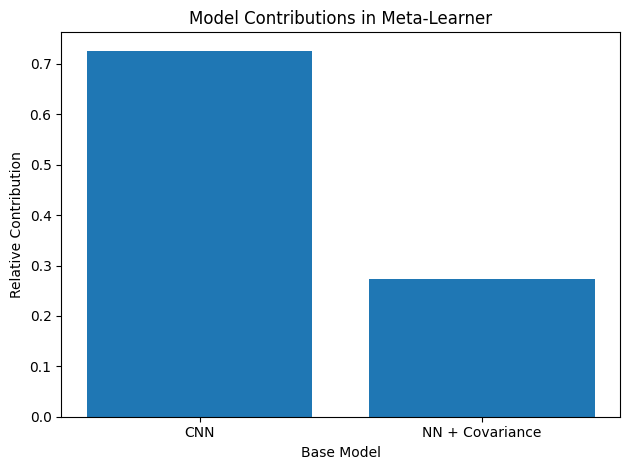

In [54]:
models = list(sums.keys())
contribs = list(sums.values())

plt.figure()
plt.bar(models, contribs)
plt.ylabel('Relative Contribution')
plt.xlabel('Base Model')
plt.title('Model Contributions in Meta-Learner')
plt.tight_layout()
plt.show()

# à completer 
"Discuss how the bias-variance tradeoff relates to the observed (or expected)
evolution of performance."

#### Question 7

In [ ]:
def predict(model, x_train, y_train, test_x):
    model.fit(X_train, y_train)
    y_predict = model.predict(test_X)
    return y_predict 


def build_csv(predict_guided, predict_free, name = "team2_submission.csv"):
    submission_array = np.vstack((predict_guided, predict_free))
    df = pd.DataFrame(submission_array)
    df.to_csv(name, index=False, header=False)

